In [282]:
#####Bi-level model for Rare temporal pattern detection####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import math
from scipy import sparse
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize
import seaborn as sns
import time

#np.random.seed(98537)

In [283]:
####データの発生####
##データの設定
k = 2   #混合数
m0 = 3   #正常状態での潜在変数数
m1 = 2   #異常状態での潜在変数数
hh = 5000   #ユーザー数
pt = np.random.poisson(np.random.gamma(50, 1/0.2, hh), hh)   #系列数
hhpt = np.sum(pt)   #総レコード数

In [284]:
##IDとインデックスを設定
#IDを設定
user_id = np.repeat(range(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))

#インデックスを設定
index = np.arange(hhpt)
user_list = [i for i in range(hh)]
user_vec = [i for i in range(hh)]
for i in range(hh):
    user_list[i] = index[user_id==i]
    user_vec[i] = np.repeat(1, pt[i])

In [285]:
##潜在パラメータとユーザーの異常状態を生成
#潜在変数のパラメータ
alpha = np.repeat(0.5, m0*m0).reshape(m0, m0) + np.diag(np.repeat(1.0, m0))
pi = 0.03   #ユーザーの混合率
gamma = np.array([0.05, 0.6])   #正常状態と異常状態の切換率
delta = 0.5   #異常状態の混合率
omega = np.append(np.random.dirichlet(np.repeat(2.5, m0), 1).reshape(-1), 0)   #正常状態の推移率の初期値
theta = np.zeros((m0+1, m0+1))
for j in range(m0):
    theta[j, ] = np.append(np.random.dirichlet(alpha[j, ], 1), 0)
theta[m0, ] = np.append(np.random.dirichlet(np.repeat(1.0, m0), 1), 0)
pit = pi; gammat = gamma; deltat = delta
omegat = omega; thetat = theta.copy()
    
#ユーザーの潜在変数を生成
Z = np.random.binomial(1, pi, hh)
index_z = np.array(np.where(Z==1)[0], dtype="int")
n = index_z.shape[0]

#異常状態の潜在変数を生成
A = np.repeat(0, hh)
A[index_z] = np.random.binomial(1, delta, n) + 1

In [286]:
##ユーザーごとに系列の異常状態を生成
#データの格納用リスト
S0_list = [i for i in range(hh)]
S_list = [i for i in range(hh)]

for i in range(hh):
    #系列の格納用配列
    s0 = np.array(np.zeros((pt[i], m0+1)), dtype="int")
    s = np.repeat(0, pt[i])

    #正常ユーザーの潜在変数を生成
    if Z[i]==0:
        for j in range(pt[i]):
            if j==0:
                s0[j, ] = np.random.multinomial(1, omega, 1)
            else:
                index = np.argmax(s0[j-1, ])
                s0[j, ] = np.random.multinomial(1, theta[index, ], 1)

    #異常ユーザーの潜在変数を生成
    else:
        for j in range(pt[i]):
            if j==0:
                s[j] = np.random.binomial(1, gamma[0], 1)
                if s[j]==0:
                    s0[j, ] = np.random.multinomial(1, omega, 1)
                else:
                    s0[j, m0] = 1
            else:
                if s[j-1]==0:
                    s[j] = np.random.binomial(1, gamma[0], 1)
                else:
                    s[j] = np.random.binomial(1, gamma[1], 1)
                if s[j]==0:
                    index = np.argmax(s0[j-1, ])
                    s0[j, ] = np.random.multinomial(1, theta[index, ], 1)
                else:
                    s0[j, m0] = 1
                    
    #生成したデータの格納
    S0_list[i] = s0
    S_list[i] = s

In [287]:
#リストを変換
S = np.array(list(itertools.chain(*[S_list[i] for i in range(hh)])))
S0 = np.array(list(itertools.chain(*[S0_list[i] for i in range(hh)])))
s_vec = np.dot(S0, np.arange(m0 + 1))
print(np.sum(S0, axis=0))

[195587 194194 859897   4128]


In [288]:
##潜在変数からデータを生成
#妥当な数値が生成されるまで繰り返す
rp = 0
while True:
    rp = rp + 1
    print(rp)
    
    #ユーザーの入力変数を生成
    k1 = 4; k2 = 4; k3 = 5
    u1 = np.array(np.random.random(hh*k1)).reshape((hh, k1))
    u2 = np.zeros((hh, k2))
    for j in range(k2):
        prob = np.random.uniform(0.25, 0.55, 1)
        u2[:, j] = np.random.binomial(1, prob, hh)
    u3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), hh)
    u3 = np.delete(u3, np.argmin(np.sum(u3, axis=0)), axis=1)   #冗長な変数の削除
    x1 = np.concatenate((np.repeat(1, hh)[:, np.newaxis], u1, u2, u3), axis=1)

    #素性ベクトルを生成
    k1 = 5; k2 = 6; k3 = 4
    u1 = np.array(np.random.random(hhpt*k1)).reshape((hhpt, k1))
    u2 = np.zeros((hhpt, k2))
    for j in range(k2):
        prob = np.random.uniform(0.25, 0.55, 1)
        u2[:, j] = np.random.binomial(1, prob, hhpt)
    u3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), hhpt)
    u3 = np.delete(u3, np.argmin(np.sum(u3, axis=0)), axis=1)   #冗長な変数の削除
    x2 = np.concatenate((u1, u2, u3), axis=1)
    x = np.hstack((x1[user_id, ], x2))
    col_x = x.shape[1]
    
    #モデルパラメータを生成
    alpha0 = np.random.uniform(2.0, 2.5, m0)
    alpha1 = np.random.uniform(2.0, 2.5, m0)
    beta0 = np.append(np.random.uniform(0.5, 2.2, m0), np.random.normal(0, 0.4, (col_x-1)*m0)).reshape(col_x, m0)
    beta1 = np.append(np.array([np.random.uniform(-1.0, -0.2, 1), np.random.uniform(2.4, 3.0, 1)]).reshape(-1), 
                      np.random.normal(0, 0.4, (col_x-1)*m1)).reshape(col_x, m1)
    alphat0 = alpha0.copy(); alphat1 = alpha1.copy()
    betat0 = beta0.copy(); betat1 = beta1.copy()

    
    #正常値のデータを生成
    y = np.repeat(0.0, hhpt)
    s0_vec = np.dot(S0, np.arange(m0+1))
    index_s0 = np.array(np.where(s0_vec!=m0)[0], dtype="int")
    N0 = index_s0.shape[0]
    mu = np.exp(np.sum(np.dot(x[index_s0, ], beta0) * S0[index_s0, :m0], axis=1))
    y[index_s0] = np.random.gamma(mu, 1/alpha0[s0_vec[index_s0]], N0)

    #異常値のデータを生成
    s1_vec = S0[:, m0]
    index_s1 = np.array(np.where(s1_vec==1)[0], dtype="int")
    N1 = index_s1.shape[0]
    mu = np.exp(np.sum(np.dot(x[index_s1, ], beta1) * np.eye(m1)[A[user_id[index_s1]]-1], axis=1))
    y[index_s1] = np.random.gamma(mu, 1/alpha1[A[user_id[index_s1]]-1], N1)

    #応答変数の集計
    s_vec[index_s1] = A[user_id[index_s1]] + m0 - 1
    y_mean = np.repeat(0.0, m0+m1)
    y_sd = np.repeat(0.0, m0+m1)
    for j in np.unique(s_vec):
        index = np.where(s_vec==j)[0]
        y_mean[j] = np.mean(y[index])
        y_sd[j] = np.std(y[index])

    #break条件
    if (np.min(y_mean[:m0]) > 1.5) & (np.max(y_mean[:m0]) < 10.0) & (y_mean[m0] < 1.0) & (y_mean[m0+1] > 10.0) & (y_mean[m0+1] < 17.5):
        break

1
2
3
4
5
6
7
8
9
10
11
12


[ 1.781  3.04   2.195  0.576 14.952]
[ 1.955  3.313  1.822  0.664 14.412]


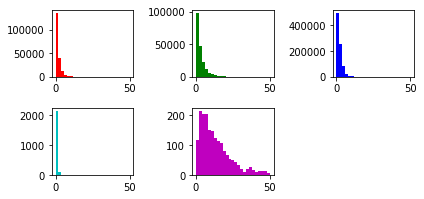

In [289]:
#生成したデータの確認
log_y = np.log(y)
print(np.round(y_mean, 3))
print(np.round(y_sd, 3))

#潜在変数ごとのヒストグラム
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
fig = plt.figure()
for j in range(m0+m1):
    ax = fig.add_subplot(3, 3, j+1)
    ax.hist(y[s_vec==j],  bins=25, range=(0, 50), color=colorlist[j])
fig.tight_layout()
plt.show()

In [290]:
####マルコフ連鎖モンテカルロ法でパラメータを推定####
##ガンマ回帰の対数尤度
def loglike(alpha, beta, d, d_log, x):
    #対数尤度を設定
    mu = np.dot(x, alpha).reshape(-1)
    Lambda = np.exp(mu)   
    Lho = beta * (-d/Lambda - mu) + beta*np.log(beta) - math.lgamma(beta) + (beta-1)*d_log
    
    #対数尤度の和
    LL = np.sum(Lho)
    return LL, Lho 
    
##HMCで尺度パラメータをサンプリングするための関数
#対数事後分布を計算する関数
def loglike_alpha(alpha, beta, tau_inv, d, d_log, x):

    #ガンマ回帰モデルの対数尤度
    mu = np.dot(x, alpha).reshape(-1)
    Lambda = np.exp(mu)   
    Lho = np.sum(beta * (-d/Lambda - mu) + beta*np.log(beta) - math.lgamma(beta) + (beta-1)*d_log)

    #多変量正規分布の対数事前分布
    log_mvn = -1/2 * np.dot(np.dot(alpha, tau_inv), alpha)

    #対数事後分布の和
    LL = Lho + log_mvn
    return LL

#ガンマ回帰の対数事後分布の微分関数
def dloglike_alpha(alpha, beta, tau_inv, d, d_log, x, n):

    #期待値の設定
    mu = np.dot(x, alpha).reshape(-1)
    Lambda = np.exp(mu)

    #微分関数の設定
    dlgamma = np.sum(((d-Lambda) / (np.power(Lambda, 2)/beta) * Lambda).reshape(n, 1) * x, axis=0)
    dmvn = np.dot(-tau_inv, alpha)

    #対数事後分布の微分関数の和
    LLd = -(dlgamma + dmvn)
    return LLd

#リープフロッグ法を解く関数
def leapfrog_alpha(r, z1, D, e, L, beta, tau_inv, d, d_log, x, n): 
    def leapfrog_step(r, z1, e):
        r2 = r - e * D(z1, beta, tau_inv, d, d_log, x, n) / 2
        z2 = z1 + e * r2
        r2 = r2 - e * D(z2, beta, tau_inv, d, d_log, x, n) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z1]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [291]:
##HMCで形状パラメータをサンプリングするための関数
#対数事後分布を計算する関数
def loglike_beta(beta, alpha_u, alpha_v, d1, d2, d_log1, d_log2, u, v, hh, item, k):

    #パラメータを設定
    beta_u = beta[0]
    beta_v = beta[1]
    
    #期待値の設定
    mu_u = np.dot(u, alpha_u).reshape(-1)
    mu_v = np.dot(v, alpha_v).reshape(-1)
    Lambda_u = np.exp(mu_u)
    Lambda_v = np.exp(mu_v)
    
    #ガンマ回帰モデルの対数尤度
    Lho1 = np.sum(beta_u * (-d1/Lambda_u - mu_u) + beta_u*np.log(beta_u) - math.lgamma(beta_u) + (beta_u-1)*d_log1)
    Lho2 = np.sum(beta_v * (-d2/Lambda_v - mu_v) + beta_v*np.log(beta_v) - math.lgamma(beta_v) + (beta_v-1)*d_log2)

    #対数事後分布の和
    LL = Lho1 + Lho2
    return LL

#形状パラメータの微分関数
def dloglike_beta(beta, alpha_u, alpha_v, d1, d2, u, v, hh, item, k):
    
    #パラメータを設定
    beta_u = beta[0]
    beta_v = beta[1]
    
    #期待値の設定
    mu_u = np.dot(u, alpha_u).reshape(-1)
    mu_v = np.dot(v, alpha_v).reshape(-1)
    Lambda_u = np.exp(mu_u)
    Lambda_v = np.exp(mu_v)
    
    #微分関数の和
    dlgamma_u = (hh*k)*(np.log(beta_u) - scipy.special.digamma(beta_u)) + np.sum(1 - d1/Lambda_u + np.log(d1/Lambda_u))
    dlgamma_v = (item*k)*(np.log(beta_v) - scipy.special.digamma(beta_v)) + np.sum(1 - d2/Lambda_v + np.log(d2/Lambda_v))
    dlgamma = -np.append(dlgamma_u, dlgamma_v)
    return dlgamma

#リープフロッグ法を解く関数
def leapfrog_beta(r, z1, D, e, L, alpha_u, alpha_v, d1, d2, u, v, hh, item, k): 
    def leapfrog_step(r, z1, e):
        r2 = r - e * D(z1, alpha_u, alpha_v, d1, d2, u, v, hh, item, k) / 2
        z2 = z1 + e * r2
        r2 = r2 - e * D(z2, alpha_u, alpha_v, d1, d2, u, v, hh, item, k) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z1]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [292]:
##アルゴリズムの設定
R = 3000
keep = 2
burnin = int(500/keep)
iter = 0
disp = 10
e1 = 0.0025
e2 = 0.01
L = 3

In [293]:
##データの設定

In [294]:
##パラメータの真値
#潜在変数の割当率のパラメータの真値
pi = pit  
gamma = gammat
delta = deltat
omega = omegat
theta = thetat

#潜在変数の真値
Zi = Z
Ai = A
Si = S
Si0 = S0

#モデルパラメータの真値
alpha0 = alphat0
alpha1 = alphat1
alpha = np.append(alpha0, alpha1)
beta0 = betat0
beta1 = betat1
beta = np.hstack((beta0, beta1))

In [295]:
i = 0
S0[user_list[i], ]

#新しい推移確率のパラメータを定義
new_omega = (1-gamma[0])*omega
new_omega[m0] = gamma[0]
new_theta = theta * np.full((m0+1, m0+1), np.append(np.repeat(1-gamma[0], m0), 1-gamma[1])).T
new_theta[:, m0] = np.append(np.repeat(gamma[0], m0), gamma[1])

In [296]:
#潜在変数ごとのガンマ回帰の尤度
Lho = np.zeros((hhpt, m0+m1))
for j in range(m0+m1):
    Lho[:, j] = np.exp(loglike(beta[:, j], alpha[j], y, log_y, x)[1])

In [297]:
Lho_new = np.hstack((Lho[:, :m0], np.sum(Lho[:, m0:], axis=1)[:, np.newaxis]))
Lho_new

array([[3.44676122e-01, 4.70089912e-02, 9.31921825e-02, 5.40161646e-01],
       [1.06591426e-01, 3.41506796e-04, 4.73366999e-02, 9.80621180e-02],
       [3.39246413e-01, 3.21075606e-03, 2.78981834e-01, 3.79989594e-01],
       ...,
       [5.65643880e-02, 4.97597725e-02, 4.43147593e-01, 2.89485577e-01],
       [2.11041075e-01, 5.79854492e-03, 2.27269493e-01, 1.16153434e-01],
       [1.35882237e-01, 1.09075166e-01, 9.12423736e-02, 1.77768757e-01]])

In [319]:
np.min(pt)

142

In [352]:
##インデックスの設定
#1回目の観測のインデックス
index_t1 = np.array(np.where(pt_id==0)[0], dtype="int")
index_t12 = index_t11 + 1
n1 = index_t1.shape[0]

#2回目以降の観測のインデックス
max_pt = np.max(pt)
user_id0 = np.append(user_id, hh)
index_t2 = [j for j in range(max_pt)]
index_t21 = [j for j in range(max_pt)]
index_t22 = [j for j in range(max_pt)]
for j in range(max_pt):
    index_t2[j] = np.array(np.where(pt_id==j)[0], dtype="int")
    index_t21[j] = index_t2[j] - 1
    index_t22[j] = index_t2[j] + 1
    index_t22[j][user_id0[index_t2[j]]!=user_id0[index_t22[j]]] = hhpt    

In [353]:
index_t22

[array([      1,     240,     521, ..., 1253120, 1253384, 1253639]),
 array([      2,     241,     522, ..., 1253121, 1253385, 1253640]),
 array([      3,     242,     523, ..., 1253122, 1253386, 1253641]),
 array([      4,     243,     524, ..., 1253123, 1253387, 1253642]),
 array([      5,     244,     525, ..., 1253124, 1253388, 1253643]),
 array([      6,     245,     526, ..., 1253125, 1253389, 1253644]),
 array([      7,     246,     527, ..., 1253126, 1253390, 1253645]),
 array([      8,     247,     528, ..., 1253127, 1253391, 1253646]),
 array([      9,     248,     529, ..., 1253128, 1253392, 1253647]),
 array([     10,     249,     530, ..., 1253129, 1253393, 1253648]),
 array([     11,     250,     531, ..., 1253130, 1253394, 1253649]),
 array([     12,     251,     532, ..., 1253131, 1253395, 1253650]),
 array([     13,     252,     533, ..., 1253132, 1253396, 1253651]),
 array([     14,     253,     534, ..., 1253133, 1253397, 1253652]),
 array([     15,     254,     535,

In [348]:
user_id[index_t2[j]]!=user_id[index_t22[j]]

IndexError: index 1253806 is out of bounds for axis 0 with size 1253806

array([   0,    0,    0, ..., 4999, 4999, 5000])

In [274]:
new_s = np.dot(S0, np.append(np.arange(m0), m0))

S0

[0.41303821 0.05694663 0.48001515 0.05      ]


array([[0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       ...,
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

In [275]:
Lho_par = np.full((n1, m0+1), new_omega) * (new_theta.T)[new_s[index_t1+1], ] * Lho_new[index_t1, ]
z_rate = Lho_par / np.sum(Lho_par, axis=1)[:, np.newaxis]

In [280]:
i = 675
print(Lho_new[index_t1[i], ])
print(y[index_t1[i]])
print(S0[index_t1[i], ])
print(z_rate[i, ])

[2.19112862e-51 2.11238713e-51 2.36196013e-38 1.19583989e-36]
5.202932015525428e-35
[0 0 0 1]
[2.19690434e-16 4.67801541e-15 1.55467494e-01 8.44532506e-01]


In [277]:
np.where(S0[index_t1, m0]==1)

(array([ 258,  627,  675,  981, 1361, 2247, 2410, 3068], dtype=int64),)

In [217]:
new_theta

array([[0.44304104, 0.49777644, 0.00918252, 0.05      ],
       [0.01279996, 0.84952897, 0.08767107, 0.05      ],
       [0.01685063, 0.29701118, 0.63613819, 0.05      ],
       [0.03793525, 0.32691839, 0.03514636, 0.6       ]])

In [75]:
np.anp.arange(m0)

array([0, 1, 2, 3])

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.6 ])